### Analysis of cannibalisation during PROMOTIONAL periods using Causal Impact (per store)

* Read the department/store data
* Read the calculated availability data or calculate it on demand
* Compare PROMO sales vs NON PROMO given the availabily
* Find the products that change their average sales
* Pick a pair of products and try the sales weighted distance analysis
* Saves the pairs in 'sku_pair_analysis'

This notebook comes from the experiments in `CFAV_simulate_cannibalisation_CausalImpact.ipynb`


Updates:

26.10.2020 - First attempt to out it all together

In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import fcn_helpers as fhelp
import fcn_simulation as fsim
from causalimpact import CausalImpact
import promotional_helpers as promies
from statsmodels.tsa.seasonal import STL

#plt.rcParams['figure.figsize'] = [14, 7]
fhelp.makeFolder('results')
pd.options.display.max_rows = None
# Use v2.0 colour cycle
def_colours = plt.rcParams['axes.prop_cycle'].by_key()['color']
# Fig sizes
fig_h = 10
fig_w = 18

# inliners
fcn_compare = lambda a,b: abs(a-b)/max(a,b)
fcn_compare_snap_vs_regular = lambda snap,reg: snap/reg
mapper_family_to_category = fhelp.cfav_get_map_dept_to_cat()

In [2]:
sku_id_A = 'DAIRY_841667'
sku_id_B = 'DAIRY_862213'

In [3]:
dataFolder = os.path.expanduser('~/Google Drive/order/Machine Learning Part/data/CorporacionFavorita')
xlsx_path = os.path.expanduser('~/Google Drive/order/Machine Learning Part/data/CorporacionFavorita')
graphsFolder = fhelp.fullfile(dataFolder, 'graphs_cannibalisation')

In [4]:
# Save the plots
save_all_cannibals = False

store_name = 'Pichincha_47_A_14'
#store_name = 'Pichincha_49_A_11'
dept_id = 'LIQUOR,WINE,BEER'
dept_id ='BREAD_BAKERY'
#dept_id ='FROZEN+FOODS'
dept_id = 'DAIRY'

# variables that pertain to the new code

# Potential cannibals
# This threshold is used to detect uplifters based on the difference in average sales
sales_threshold = 1/3
# min AVG sales to be considered
min_avg_sales = 10


# This is the minimum bump between regular and promo
# and promo back to regular *0.25
min_diff_in_units_from_reg_to_promo = 5
# when analysing the SKUs
min_promo_days=3
min_regular_days=6

# values for the CI analysis
min_ratio_change = 0.4
do_exclude_promos_SKU_B = True
# This flag is pretty good for debugging/development
be_verbose=False



# LOESS - weekly
period_in_days = 7

# If true, use the sales without the weekly pattern
do_decomposition = False


# This threshold is used to detect the reduction in sales that one uplifter causes
cannibalisation_threshold = 1/3

# min days/times that both products overlap during the promotions of the cannibal
min_snap_days = 10

# N/A
#price_threshold = 2

#### Read the store level data

In [5]:
# Read departement sales for the current store
category_id = mapper_family_to_category.get(dept_id, '')
foldername = os.path.join(dataFolder, category_id, dept_id, 'store_sales')
filename = os.path.join(foldername, f'{store_name}.pickle')
df_store = fhelp.readPickleFile(filename)

sales_vars = [iVar for iVar in df_store.columns if 'sales-' in iVar]
promotion_vars = [iVar for iVar in df_store.columns if 'promotion_flag-' in iVar]

### Add weather data and the trend of the department sales

In [6]:
weather_file = os.path.join(dataFolder, 'weather_data','daily_weather_in_Quito2017_no_header.pickle')
df_weather = pd.read_pickle(weather_file)[['date', 'avg_temp','wind_speed','total_precipitation', 'T2M_MAX_adj', 'T2M_MIN_adj']]

df_store = pd.merge(df_store, df_weather, how='inner', on='date')

sales_decomposition_LOESS = STL(df_store['total_units'], period=period_in_days).fit()
df_store['total_units_trend'] = sales_decomposition_LOESS.trend

df_store.head(2)

,date,weekdays,sales-DAIRY_122095-Pichincha_47_A_14,promotion_flag-DAIRY_122095-Pichincha_47_A_14,sales-DAIRY_123347-Pichincha_47_A_14,promotion_flag-DAIRY_123347-Pichincha_47_A_14,sales-DAIRY_129635-Pichincha_47_A_14,promotion_flag-DAIRY_129635-Pichincha_47_A_14,sales-DAIRY_158842-Pichincha_47_A_14,promotion_flag-DAIRY_158842-Pichincha_47_A_14,...,promotion_flag-DAIRY_2087567-Pichincha_47_A_14,sales-DAIRY_2112404-Pichincha_47_A_14,promotion_flag-DAIRY_2112404-Pichincha_47_A_14,total_units,avg_temp,wind_speed,total_precipitation,T2M_MAX_adj,T2M_MIN_adj,total_units_trend
0,2017-01-01,Sunday,0.0,False,0.0,False,0.0,False,0.0,False,...,False,0.0,False,0.0,11.03,3.62,6.29,20.139417,8.599041,2018.181432
1,2017-01-02,Monday,8.0,True,17.0,False,33.0,True,13.0,False,...,False,0.0,False,4618.0,11.13,4.15,4.42,20.100002,8.515361,2250.696711


In [7]:
results_folder = 'CFAV_cannibalisation_analysis'

category_id = mapper_family_to_category.get(dept_id, '')
foldername = os.path.join(dataFolder, results_folder, category_id, dept_id)
fhelp.makeFolder(foldername)
filename = os.path.join(foldername, f'{dept_id}-{store_name}.pickle')

#### Exclude the holiday periods from the analysis
Include it in the skus's heartbeat in the analysis below

In [8]:
preXmas  = df_store.date >= '2016-12-21'
postXmas = df_store.date < '2017-01-04'
idx_Xmas = (preXmas & postXmas).values

# at the moment only Xmas
idx_holiday_to_exclude = idx_Xmas

#### Read the store level sales decomposition
Generate the file if required
- (sales)
- heartbeat
- trend
- seasonal 
- residual

In [9]:
# Sales decomposition - on demand
folderDecomposition = os.path.join(os.path.expanduser(dataFolder), 'sku_decomposition', category_id, dept_id)
filename = os.path.join(folderDecomposition, f'{store_name}.pickle')

if os.path.exists(filename):
    df_components = fhelp.readPickleFile(filename)
else:
    decomposed_skus = []

    # Season-Trend decomposition using LOESS
    for idx_sku, sku_name in enumerate(sales_vars):

        item_id = sku_name.split('-')[1]

        current_sales = df_store[sku_name]

        df_decomposition = fhelp.decompose_signal(current_sales, \
            period_in_days=period_in_days, minimum_heartbeat=0.85)

        rename_map = {iCol: f'{iCol}-{item_id}-{store_name}' for iCol in df_decomposition.columns}
        decomposed_skus.append(df_decomposition.rename(columns=rename_map))

    df_components = pd.concat(decomposed_skus, axis=1)

    df_components['date'] = df_store.date
    df_components['weekdays'] = df_store.weekdays

    fhelp.makeFolder(folderDecomposition)
    fhelp.toPickleFile(df_components, filename)
    print(f'Saving {filename}...')
    
df_components.head(3)

,heartbeat_flag-DAIRY_122095-Pichincha_47_A_14,trend-DAIRY_122095-Pichincha_47_A_14,seasonal-DAIRY_122095-Pichincha_47_A_14,residual-DAIRY_122095-Pichincha_47_A_14,heartbeat_flag-DAIRY_123347-Pichincha_47_A_14,trend-DAIRY_123347-Pichincha_47_A_14,seasonal-DAIRY_123347-Pichincha_47_A_14,residual-DAIRY_123347-Pichincha_47_A_14,heartbeat_flag-DAIRY_129635-Pichincha_47_A_14,trend-DAIRY_129635-Pichincha_47_A_14,...,heartbeat_flag-DAIRY_2087567-Pichincha_47_A_14,trend-DAIRY_2087567-Pichincha_47_A_14,seasonal-DAIRY_2087567-Pichincha_47_A_14,residual-DAIRY_2087567-Pichincha_47_A_14,heartbeat_flag-DAIRY_2112404-Pichincha_47_A_14,trend-DAIRY_2112404-Pichincha_47_A_14,seasonal-DAIRY_2112404-Pichincha_47_A_14,residual-DAIRY_2112404-Pichincha_47_A_14,date,weekdays
0,True,6.563208,-1.972374,-4.590833,True,9.366023,-2.082336,-7.283686,True,22.352092,...,False,-7.806400e-12,6.698409e-12,1.107991e-12,False,-2.675906e-15,2.126802e-15,5.491047e-16,2017-01-01,Sunday
1,True,7.329679,0.235266,0.435055,True,10.084465,2.636614,4.278921,True,25.295232,...,False,-5.897083e-12,6.191599e-12,-2.945153e-13,False,-2.050083e-15,2.007485e-15,4.259794e-17,2017-01-02,Monday
2,True,8.007992,1.253958,3.738050,True,10.713568,1.251354,4.035078,True,28.091335,...,False,-4.032322e-12,5.466908e-12,-1.434586e-12,False,-1.425929e-15,1.871448e-15,-4.455195e-16,2017-01-03,Tuesday


## Compare PROMOS sales vs NON PROMOS given the availabily (comparing windows of non-promos/promos)

Given the inferred availability of the SKU, calculate the following parameters for SNAP and regular periods: average sales and the standard deviation, the median and the number of days within each category.

```python
{'num_promo_slots': 2,
 'avg_promo_sales': 55.51020408163265,
 'avg_regular_sales': 41.74285714285714,
 'difference_averages_promo_to_regular': 13.76734693877551,
 'cum_difference_sales_promo_to_regular': -202.0,
 'slot_promo_avg_sales': array([56., 52.]),
 'slot_regular_avg_sales': array([37.38461538, 42.73684211]),
 'availability_value_sku_A': 0.986784140969163}
```


Then we simply select the uplifters as those SKUs that during SNAP periods have sales greater than:

'median_snap_sales'>=('median_regular_sales'*(1+sales_threshold))

### Comparison only valid if sales larger than zero
idx_B = (df_snap_stats['median_snap_sales']>0) & (df_snap_stats['median_regular_sales']>0)


### Meaning of uplifters and downlifters

Uplifters are SKU that simply sell more when on promotion. Downlifters here are a bit of a special case as when they are on promo they sell less. The promos are sku-level, unlike SNAP or NATIONAL events.

In [10]:
folderPromoStats = os.path.join(os.path.expanduser(dataFolder), 'sku_promo_slot_analysis', category_id, dept_id)
filename = os.path.join(folderPromoStats, f'{store_name}.pickle')

if os.path.exists(filename):
    df_snap_stats = fhelp.readPickleFile(filename)
else:
    # List of products
    sku_analysis = []

    for sku_A in sales_vars:
        # Get the taxonomy
        category_id, dept_id, sku_id, store_name = fhelp.get_taxonomy_from_sku_name_CFAV(sku_A)
        state_name = store_name.split('_')[0]

        sku_A_behaviour = promies.compare_promo_regular_sales(df_store, df_components, sku_A, \
            idx_holiday_to_exclude, min_promo_days=min_promo_days, min_regular_days=min_regular_days)

        sku_analysis.append(sku_A_behaviour)
        
    # Stick the dicts into a DF
    df_snap_stats = pd.DataFrame(sku_analysis)
    df_snap_stats.index = sales_vars

    idx_nonsense = df_snap_stats.num_promo_slots.isna() | (df_snap_stats.num_promo_slots < 1)
    df_snap_stats = df_snap_stats[~idx_nonsense].copy()

    # for backwards compatibility
    df_snap_stats['mu_difference'] = df_snap_stats['difference_averages_promo_to_regular']
    # Add a small offset to avoid 0-divisions
    df_snap_stats['mu_delta'] = df_snap_stats[['avg_promo_sales', 'avg_regular_sales']].apply(lambda snap_reg: (snap_reg[0]+0.01)/(snap_reg[1]+0.01), axis=1)
    
    # save the file
    df_snap_stats.sort_values(by=['mu_delta'], ascending=False, inplace=True)
    
    fhelp.makeFolder(folderPromoStats)
    fhelp.toPickleFile(df_snap_stats, filename)

In [11]:
df_snap_stats.head(3)

,num_promo_slots,avg_promo_sales,avg_regular_sales,difference_averages_promo_to_regular,cum_difference_sales_promo_to_regular,slot_promo_avg_sales,slot_regular_avg_sales,availability_value_sku_A,mu_difference,mu_delta
sales-DAIRY_1332664-Pichincha_47_A_14,3.0,12.629630,2.092784,10.536846,138.0,"[13.526315789473685, 10.0, 11.0]","[0.0, 4.333333333333333, 4.0]",0.801762,10.536846,6.010904
sales-DAIRY_849095-Pichincha_47_A_14,2.0,12.379310,2.351351,10.027959,272.0,"[14.136363636363637, 6.857142857142857]","[1.8333333333333333, 3.3076923076923075]",0.973568,10.027959,5.246703
sales-DAIRY_2053614-Pichincha_47_A_14,2.0,35.243243,6.901515,28.341728,393.0,"[40.529411764705884, 30.75]","[2.0294117647058822, 12.078125]",0.757709,28.341728,5.100653


#### Uplifters

In [12]:
# A bit of work on the uplifters
# Snap sales greater than the sales + threshold
idx_A = df_snap_stats['mu_delta']>=(1+sales_threshold)

# Comparison only valid if they are not zero sales
idx_B = (df_snap_stats['avg_promo_sales']>min_avg_sales) & (df_snap_stats['avg_regular_sales']>min_avg_sales)
df_snap_stats['uplift_in_median'] = (idx_A & idx_B)

# Get two groups: potential cannibals (and haloers) and victims
df_snap_uplifters = df_snap_stats[df_snap_stats['uplift_in_median']].copy()

In [13]:
num_uplifters = df_snap_uplifters.shape[0] 
valid_uplifters = num_uplifters > 0
df_snap_uplifters.sort_values(by=['mu_delta', 'mu_difference'], ascending=False, inplace=True)
#fhelp.to_random_excel_file(df_snap_uplifters, writeIndex=True)
df_snap_uplifters.head(3)

,num_promo_slots,avg_promo_sales,avg_regular_sales,difference_averages_promo_to_regular,cum_difference_sales_promo_to_regular,slot_promo_avg_sales,slot_regular_avg_sales,availability_value_sku_A,mu_difference,mu_delta,uplift_in_median
sales-DAIRY_1239782-Pichincha_47_A_14,1.0,36.700000,12.735294,23.964706,-132.0,[36.7],[12.735294117647058],0.986784,23.964706,2.880279,True
sales-DAIRY_1239844-Pichincha_47_A_14,1.0,29.136364,11.027778,18.108586,-550.0,[29.136363636363637],[11.027777777777779],0.986784,18.108586,2.640601,True
sales-DAIRY_1239845-Pichincha_47_A_14,1.0,29.727273,11.833333,17.893939,-624.0,[29.727272727272727],[11.833333333333334],0.986784,17.893939,2.510887,True


In [14]:
sku_A = f'sales-{sku_id_A}-Pichincha_47_A_14'
df_snap_uplifters.loc[sku_A]

num_promo_slots                                                                2
avg_promo_sales                                                          18.6286
avg_regular_sales                                                        11.3939
difference_averages_promo_to_regular                                     7.23463
cum_difference_sales_promo_to_regular                                       -852
slot_promo_avg_sales                     [20.17241379310345, 11.166666666666666]
slot_regular_avg_sales                   [12.662650602409638, 9.244897959183673]
availability_value_sku_A                                                0.986784
mu_difference                                                            7.23463
mu_delta                                                                  1.6344
uplift_in_median                                                            True
Name: sales-DAIRY_841667-Pichincha_47_A_14, dtype: object

## Pick one example

In [15]:
min_diff_in_units_from_reg_to_promo=5

In [16]:


folderCausalImpactResults = os.path.join(os.path.expanduser(dataFolder), 'CausalImpactResults', category_id, dept_id)
filenameCI = os.path.join(folderCausalImpactResults, f'{store_name}.pickle')
df_CI_analysis = fhelp.readPickleFile(filenameCI)

sales_sku_A = df_store[f'sales-{sku_id_A}-{store_name}']
sales_sku_B = df_store[f'sales-{sku_id_B}-{store_name}']
promo_sku_A = df_store[f'promotion_flag-{sku_id_A}-{store_name}']
availability_sku_A = df_components[f'heartbeat_flag-{sku_id_A}-{store_name}']
availability_sku_B = df_components[f'heartbeat_flag-{sku_id_B}-{store_name}']
promo_sku_B = df_store[f'promotion_flag-{sku_id_B}-{store_name}']

idx_pre_intervention, idx_post_intervention = \
    fhelp.split_promos_into_sequences(promo_sku_A, min_promo_days=min_promo_days, min_regular_days=min_regular_days)

ci_analysis = promies.calculate_causal_impact(sku_id_A, promo_sku_A, availability_sku_A, sales_sku_A, \
    sku_id_B, promo_sku_B, availability_sku_B, sales_sku_B, \
    idx_pre_intervention, idx_post_intervention, \
    idx_holiday_to_exclude, \
    min_diff_in_units_from_reg_to_promo, \
    min_ratio_change = min_ratio_change,\
    do_exclude_promos_SKU_B = do_exclude_promos_SKU_B, \
    be_verbose=be_verbose)

ci_analysis

Running Causal Impact...


/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


CausalImpact >> Probability of a causal event 100.00


[{'cannibal': 'DAIRY_841667',
  'victim': 'DAIRY_862213',
  'slot_number': 0,
  'idx_regular_days': [39, 121],
  'idx_promo_days': [122, 150],
  'total_overlapping_days_regular': 83,
  'regular_to_promo_gap': 0,
  'total_overlapping_days_promo': 29,
  'competing_promo_days': 0,
  'sku_B_regular_avg_sales': 12.783132530120483,
  'sku_B_avg_sales_during_promo_sku_A': 7.344827586206897,
  'diff_in_units_from_reg_to_promo': 5.438304943913586,
  'diff_in_units_from_promo_to_pos_promo': -2.3694581280788167,
  'ratio_change': 0.42542819071143034,
  'avg_actual': 7.344827586206897,
  'avg_predicted': 12.971173260130007,
  'avg_abs_effect': -5.62634567392311,
  'cum_abs_effect': -163.1640245437702,
  'posterior_tail_prob': 0.0,
  'prob_causal_effect': 100.0}]

### Covariates

In [17]:

folderCausalImpactResults = os.path.join(os.path.expanduser(dataFolder), 'CausalImpactResults', category_id, dept_id)
filenameCI = os.path.join(folderCausalImpactResults, f'{store_name}.pickle')
df_CI_analysis = fhelp.readPickleFile(filenameCI)

df_sales_covariates = df_store[[f'sales-{sku_id_B}-{store_name}', 'total_units_trend', 'T2M_MAX_adj']]
sales_sku_A = df_store[f'sales-{sku_id_A}-{store_name}']
sales_sku_B = df_store[f'sales-{sku_id_B}-{store_name}']
promo_sku_A = df_store[f'promotion_flag-{sku_id_A}-{store_name}']
availability_sku_A = df_components[f'heartbeat_flag-{sku_id_A}-{store_name}']
availability_sku_B = df_components[f'heartbeat_flag-{sku_id_B}-{store_name}']
promo_sku_B = df_store[f'promotion_flag-{sku_id_B}-{store_name}']




idx_pre_intervention, idx_post_intervention = \
    fhelp.split_promos_into_sequences(promo_sku_A, min_promo_days=min_promo_days, min_regular_days=min_regular_days)

ci_analysis = promies.calculate_causal_impact_with_covariates(sku_id_A, promo_sku_A, availability_sku_A, sales_sku_A, \
    sku_id_B, promo_sku_B, availability_sku_B, 
    df_sales_covariates, \
    idx_pre_intervention, idx_post_intervention, \
    idx_holiday_to_exclude, \
    min_diff_in_units_from_reg_to_promo, \
    min_ratio_change = min_ratio_change,\
    do_exclude_promos_SKU_B = do_exclude_promos_SKU_B, \
    be_verbose=be_verbose)

ci_analysis

Running Causal Impact...


/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/usr/local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


CausalImpact >> Probability of a causal event 99.40


[{'cannibal': 'DAIRY_841667',
  'victim': 'DAIRY_862213',
  'slot_number': 0,
  'idx_regular_days': [39, 121],
  'idx_promo_days': [122, 150],
  'total_overlapping_days_regular': 83,
  'regular_to_promo_gap': 0,
  'total_overlapping_days_promo': 29,
  'competing_promo_days': 0,
  'sku_B_regular_avg_sales': 12.783132530120483,
  'sku_B_avg_sales_during_promo_sku_A': 7.344827586206897,
  'diff_in_units_from_reg_to_promo': 5.438304943913586,
  'diff_in_units_from_promo_to_pos_promo': -2.3694581280788167,
  'ratio_change': 0.42542819071143034,
  'avg_actual': 7.344827586206897,
  'avg_predicted': 11.414287579212344,
  'avg_abs_effect': -4.069459993005447,
  'cum_abs_effect': -118.01433979715796,
  'posterior_tail_prob': 0.005994005994005994,
  'prob_causal_effect': 99.4005994005994}]

In [18]:
from causalimpact import CausalImpact

In [ ]:
input_vars = ['total_units', f'sales-{sku_id_A}-{store_name}', f'sales-{sku_id_B}-{store_name}']


num_days = np.arange(promo_sku_A.shape[0])

idx_promo_slot = 0
idx_pre_intervention_current = idx_pre_intervention[idx_promo_slot]
idx_post_intervention_current = idx_post_intervention[idx_promo_slot]

# Calculation here with the availability
combined_availability = availability_sku_A & availability_sku_B & (~idx_holiday_to_exclude)
idx_overlapping_days_promo = combined_availability & idx_post_intervention_current
total_overlapping_days_promo = idx_overlapping_days_promo.sum()

# overlapping promo days. Both SKUs on promo, "competing promos"
idx_competing_promo_days = idx_overlapping_days_promo & promo_sku_B
competing_promo_days = idx_competing_promo_days.sum()
idx_overlapping_days_regular = combined_availability & idx_pre_intervention_current

ind_regular_days = num_days[idx_overlapping_days_regular]
start_regular = ind_regular_days.min()
end_regular = ind_regular_days.max()

ind_promo_days = num_days[idx_overlapping_days_promo]
start_promo = ind_promo_days.min()
end_promo = ind_promo_days.max()

idx_regular_days = np.array([start_regular, end_regular]).tolist()
idx_promo_days   = np.array([start_promo, end_promo]).tolist()

ind_regular_days = num_days[idx_overlapping_days_regular]



In [79]:
### Produce the graph for the paper

In [103]:
use_trend_total_sales=True
save_to_file = True
folder_to_save_plots = 'paper_plots'


f, ax = plt.subplots(2,1,figsize=(fig_w*1.5*1.5, fig_h*1.5))
plt.rcParams.update({'font.size': 25})

store_alias = f'''Store_{store_name.split('_')[1]}'''

category_id, dept_id, _, store_name = fhelp.get_taxonomy_from_sku_name_CFAV(sku_A)


irow = pd.DataFrame(ci_analysis).loc[0]

start_period = irow.idx_promo_days[0]
end_period = irow.idx_promo_days[1]+1

sku_B_reg = irow['sku_B_regular_avg_sales']
sku_B_cannibalised = irow['sku_B_avg_sales_during_promo_sku_A']
sku_B_predicted = irow['avg_predicted']

slot_number = irow['slot_number']

x_axis = df_store.date

idx_store = 0
# Plot one store


idx_axis = 0
sales_sku_A = df_store[f'sales-{sku_id_A}-{store_name}']
ax[0].plot(x_axis, sales_sku_A, label=f'Sales CN {sku_id_A}',
        color=def_colours[idx_store], linewidth=3, alpha=0.65)

sales_sku_B = df_store[f'sales-{sku_id_B}-{store_name}']
ax[0].plot(x_axis, sales_sku_B, label=f'Sales VC {sku_id_B} (reg={sku_B_reg:3.2f})',
        color=def_colours[idx_store+1], linewidth=3, alpha=0.65)

ax[0].plot(x_axis.iloc[start_period:end_period], sales_sku_A.iloc[start_period:end_period],
        color=def_colours[idx_store], linewidth=4, alpha=0.95)

ax[0].plot(x_axis.iloc[start_period:end_period], sales_sku_B.iloc[start_period:end_period],
        color=def_colours[idx_store+1], linewidth=4, alpha=0.95)

ax[0].axvspan(x_axis.iloc[start_period], x_axis.iloc[end_period], alpha=0.1, color='red')

promo_sku_A = df_store[f'promotion_flag-{sku_id_A}-{store_name}']
ax[0].plot(x_axis[promo_sku_A], sales_sku_A[promo_sku_A], '.', label=f'Promo days {sku_id_A} (can={sku_B_cannibalised:3.2f}, pred={sku_B_predicted:3.2f})', 
            color='g', linewidth=3.5, alpha=0.85)


promo_sku_B = df_store[f'promotion_flag-{sku_id_B}-{store_name}']
ax[0].plot(x_axis[promo_sku_B], sales_sku_B[promo_sku_B], 'o', label=f'Promo days {sku_id_B}', 
            color=def_colours[-4], linewidth=5.5, alpha=0.95)

ax[0].legend()
ax[0].set_xlabel('dates')
ax[0].set_ylabel(f'Analysis {store_alias}')
ax[0].grid(True)
ax[0].margins(0,0.05)



# Add the exogenous data
present_var = 'total_units_trend' in df_store.columns.tolist()
if use_trend_total_sales & present_var:
    total_units_signal = df_store['total_units_trend']
    ax[1].plot(x_axis, df_store['total_units_trend'], label=f'Trend total sales CN {dept_id}',
            color=def_colours[idx_store], linewidth=2, alpha=0.85)
    ax[1].plot(x_axis, df_store['total_units'], color=def_colours[idx_store], linewidth=1, alpha=0.35)
else:
    total_units_signal = df_store['total_units']
    ax[1].plot(x_axis, total_units_signal, label=f'Total sales {dept_id}',
            color=def_colours[idx_store], linewidth=2, alpha=0.85)



ax2 = ax[1].twinx()

ax2.plot(x_axis, df_store['T2M_MAX_adj'], label=f'Avg day temperature (C)',
        color='g', linewidth=2, alpha=0.45)


lines, labels = ax[1].get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

ax[1].set_xlabel('dates')
ax[1].set_ylabel('Exogenous variables')
ax[1].grid(True)
ax[1].margins(0,0)
ax2.margins(0,0)

plt.tight_layout()
if save_to_file:
    print(category_id, dept_id)
    foldername_png = os.path.join(folder_to_save_plots, category_id, dept_id, 'causal_plots', store_name)
    fhelp.makeFolder(foldername_png)
    plt_filename = os.path.join(foldername_png, f'{sku_id_A}-{sku_id_B}-{slot_number}.pdf')
    plt.savefig(plt_filename)
    plt.close()
    print(f'File saved to {plt_filename}')
else:
    plt.show()

FOOD DAIRY
File saved to paper_plots/FOOD/DAIRY/causal_plots/Pichincha_47_A_14/DAIRY_841667-DAIRY_862213-0.pdf


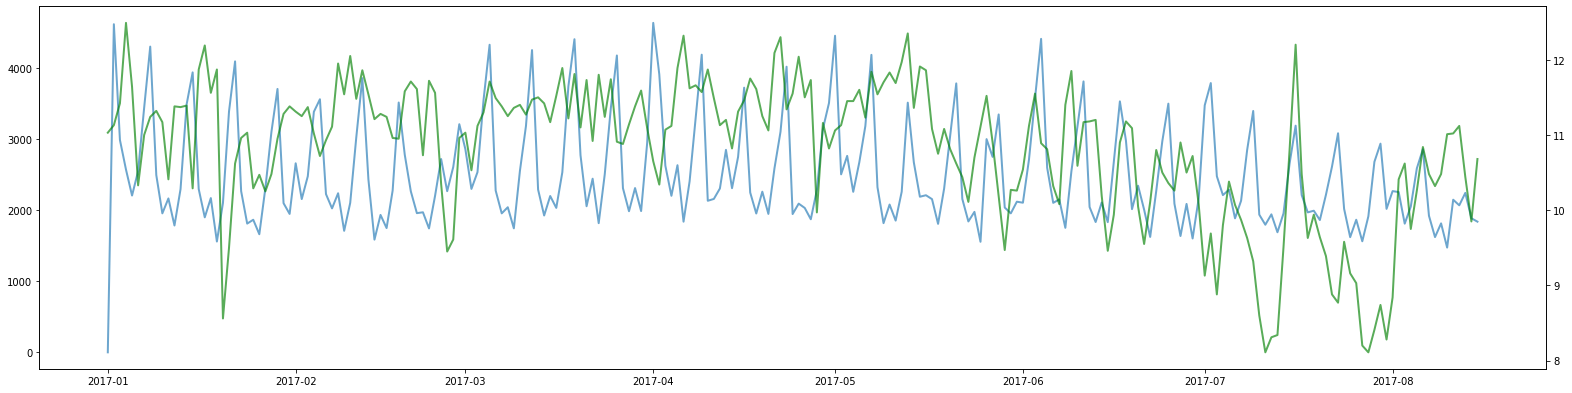

In [37]:
f, ax = plt.subplots(1,1,figsize=(fig_w*1.5, fig_h/1.5))

# 	avg_temp	wind_speed	total_precipitation
ax.plot(x_axis, df_store['total_units'], label=f'Total sales CN {dept_id}-{store_name}',
        color=def_colours[idx_store], linewidth=2, alpha=0.65)

ax2 = ax.twinx()

ax2.plot(x_axis, df_store['avg_temp'], label=f'Avg temperature (C) for{store_name}',
        color='g', linewidth=2, alpha=0.65)

In [36]:
ci = CausalImpact(df_store[input_vars], idx_regular_days, idx_promo_days, prior_level_sd=None)
ci.summary_data

,average,cumulative
actual,2477.517241,71848.000000
predicted,2348.845567,68116.521431
predicted_lower,2106.186233,61079.400754
predicted_upper,2590.879877,75135.516442
abs_effect,128.671675,3731.478569
abs_effect_lower,-113.362636,-3287.516442
abs_effect_upper,371.331008,10768.599246
rel_effect,0.054781,0.054781
rel_effect_lower,-0.048263,-0.048263
rel_effect_upper,0.158091,0.158091


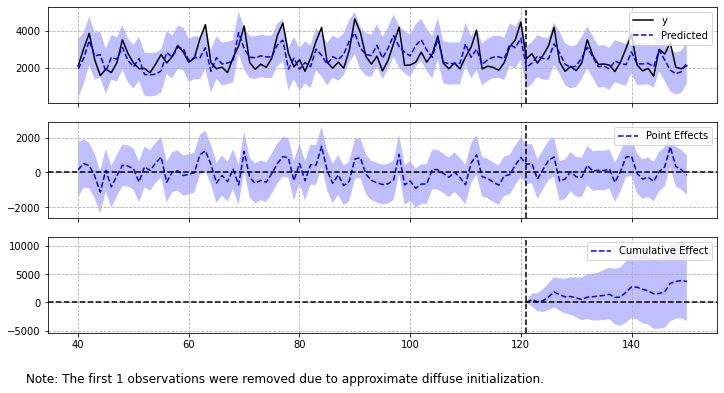

In [37]:
ci.plot(figsize=(12, 6))